# Thermovision segmentation (altitude & angle version)

## HIT-UAV Dataset

*HIT-UAV provides essential flight data for each image, including flight altitude, camera perspective, date, and daylight intensity. <br>
For each image, the authors have manually annotated object instances with bounding boxes of two types (oriented and standard) <br>to tackle the challenge of significant overlap of object instances in aerial images.*

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from src.utils.read_file import XMLReader, read_file_to_list
from src.visualizations import plot_oriented_annotations

ANNOTATIONS_PATH = "data/HIT-UAV-Infrared-Thermal-Dataset/rotate_xml/Annotations"
DATA_SPLIT_PATH = "data/HIT-UAV-Infrared-Thermal-Dataset/rotate_xml/ImageSets/Main"
IMAGES_PATH = "data/HIT-UAV-Infrared-Thermal-Dataset/rotate_xml/JPEGImages"

#### Load annotations

In [13]:
xml_reader = XMLReader(ANNOTATIONS_PATH)
annotations = xml_reader.getAnnotation()

In [14]:
# examplary annotation
annotations['0_100_30_0_03280']

{'picname': '0_100_30_0_03280.jpg',
 'size': {'width': 640, 'height': 512, 'depth': 1},
 'nobbox': [],
 'robbox': [{'category': 'Car',
   'cx': 215.984,
   'cy': 120.9863,
   'w': 32.276,
   'h': 15.9103,
   'angle': 2.589049,
   'difficult': False},
  {'category': 'Car',
   'cx': 373.7907,
   'cy': 97.5358,
   'w': 27.4285,
   'h': 19.3339,
   'angle': 0.559865,
   'difficult': False},
  {'category': 'Car',
   'cx': 134.6054,
   'cy': 141.7191,
   'w': 25.4252,
   'h': 18.4471,
   'angle': 2.279669,
   'difficult': False},
  {'category': 'Car',
   'cx': 32.4545,
   'cy': 200.0871,
   'w': 27.7836,
   'h': 13.3051,
   'angle': 0.796474,
   'difficult': False},
  {'category': 'Car',
   'cx': 43.7676,
   'cy': 192.7359,
   'w': 31.907,
   'h': 17.0008,
   'angle': 0.650521,
   'difficult': False},
  {'category': 'Car',
   'cx': 58.5022,
   'cy': 187.6378,
   'w': 14.5995,
   'h': 32.0022,
   'angle': 2.335935,
   'difficult': False},
  {'category': 'Car',
   'cx': 67.869,
   'cy': 181.10

In [15]:
image_names = dict()
for key in ["train", "val", "test"]:
    image_names[key] = read_file_to_list(f"{DATA_SPLIT_PATH}/{key}.txt")

#### Visualize n random images from the training set

In [16]:
n = 15
random_images = np.random.choice(np.arange(len(image_names['train'])), n, replace=False)
random_images = [image_names['train'][i] for i in random_images]
# random_images

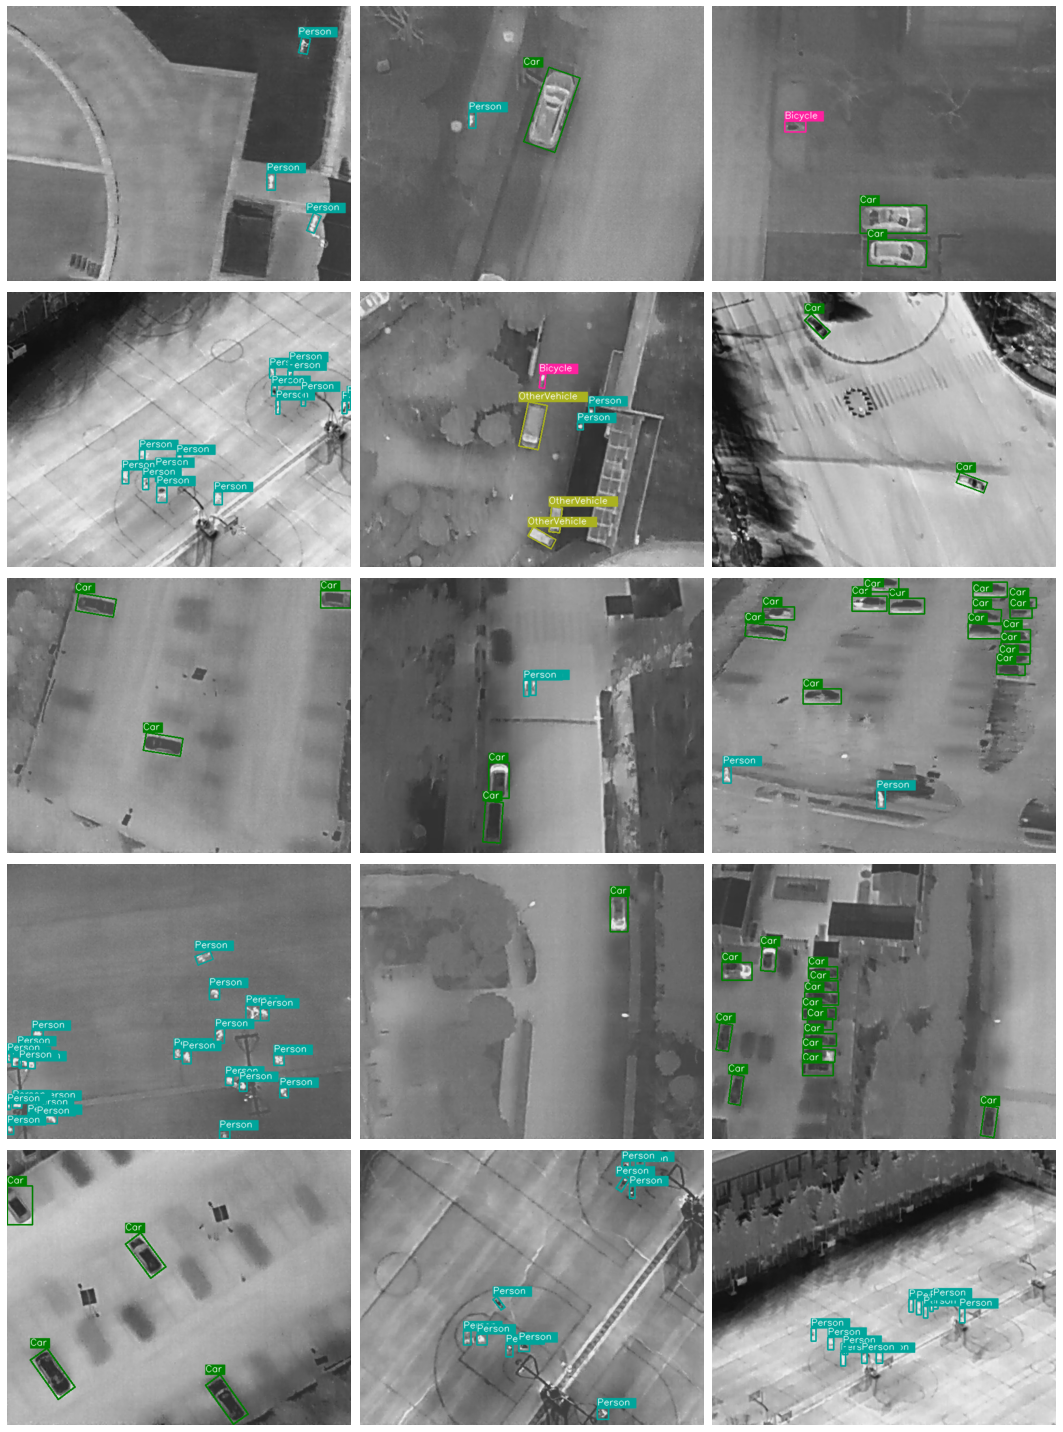

In [17]:
rows = 5
cols = 3
figsize = (15, 20)

fig, axes = plt.subplots(rows, cols, figsize=figsize)
axes = axes.flatten()

if len(random_images) > rows * cols:
    raise ValueError("Number of images to display exceeds the number of subplots")

for idx, image_name in enumerate(random_images):
    img_path = f"{IMAGES_PATH}/{image_name}.jpg"
    img = cv2.imread(img_path)
    
    img_with_annotations = plot_oriented_annotations(img, annotations[image_name])
    axes[idx].imshow(cv2.cvtColor(img_with_annotations, cv2.COLOR_BGR2RGB))
    axes[idx].set_axis_off()

for ax in axes[len(random_images):]:
    ax.axis("off")

plt.tight_layout()
plt.show()
